In [1]:
import os
import pickle
import numpy as np

from spenderq import load_model
from spenderq import util as U
from spenderq import lyalpha as LyA

In [2]:
import umap.plot

/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/

In [3]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [4]:
niter = 3
with open('london.lfsc.rsnr.sa1p1sb0p8.i%i.umap.pkl' % niter, 'rb') as f:
    umapper = pickle.load(f)

In [5]:
#models, losses = load_model('/tigress/chhahn/spender_qso/models/qso.london.z_2p1_3p5.rebin.iter%i.pt' % niter)
models, losses = load_model('/tigress/chhahn/spender_qso/models/london.lfsc.rsnr.sa1p1sb0p8.i%i.pt' % niter)

specs, recon, true_cont = [], [], []
redshifts, weights, tids, norms, latents = [], [], [], [], []
for ibatch in range(50): 
    # load batch
    with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.pkl' % (niter, ibatch), "rb") as f:
        spec, w, z, target_id, norm, zerr = pickle.load(f)
    specs.append(np.array(spec))
    tids.append(np.array(target_id))
    norms.append(np.array(norm))
    redshifts.append(np.array(z))
    weights.append(np.array(w))
    
    # latents
    #latents.append(np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.latents.npy' % (niter, ibatch)))
    #latents.append(np.load('/tigress/chhahn/spender_qso/train/london.rebin.iter%i.simconloss_%i.latents.npy' % (niter, ibatch)))
    latents.append(np.load('/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p1sb0p8.i%i_%i.latents.npy' % (niter, ibatch)))

    # load SpenderQ recon 
    #recon.append(np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.recons.npy' % (niter, ibatch)))
    #recon.append(np.load('/tigress/chhahn/spender_qso/train/london.rebin.iter%i.simconloss_%i.recons.npy' % (niter, ibatch)))
    recon.append(np.load('/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p1sb0p8.i%i_%i.recons.npy' % (niter, ibatch)))

    # load true continuum
    true_cont.append(np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch)))
    
specs = np.concatenate(specs, axis=0)
tids = np.concatenate(tids)
norms = np.concatenate(norms)
redshifts = np.concatenate(redshifts)
weights = np.concatenate(weights, axis=0)
latents = np.concatenate(latents)

recon = np.concatenate(recon, axis=0)
true_cont = np.concatenate(true_cont, axis=0)

w_recon = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i.wave_recon.npy' % niter)

/home/chhahn/projects/SpenderQ/src/spenderq/__init__.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_struct = torch.load(filename, map_location=device)
/tmp/ipyke

In [6]:
wave_rest_rebin = np.linspace(800, 3000, 2000)

In [7]:
# continuum residual over full wavelength

dcont_recon, dfcont_recon = [], []
bad_recon = []
for igal in range(len(redshifts)): 
    wlim = (wave_rest_rebin > 3.6e3/float(1+redshifts[igal])) & ((wave_rest_rebin < 9.9e3/float(1+redshifts[igal])))
    
    # rebin true continuum
    true_rebin = U.trapz_rebin(
        np.linspace(3.50e3, 1e4, 3251)/float(1 + redshifts[igal]), 
        np.array(true_cont[igal]/norms[igal]), 
        xnew=wave_rest_rebin[wlim])
    
    # rebin reconstruction
    recon_rebin = U.trapz_rebin(
        w_recon, 
        recon[igal], 
        xnew=wave_rest_rebin[wlim])
    
    # residual
    dcont = np.repeat(-999., len(wave_rest_rebin))
    dcont[wlim] = true_rebin - recon_rebin 
    
    # fractional residual
    dfcont = np.repeat(-999., len(wave_rest_rebin))
    dfcont[wlim] = (true_rebin - recon_rebin)/true_rebin

    dcont_recon.append(dcont)
    dfcont_recon.append(dfcont)
    
    # check for bad recons
    wlim = (wave_rest_rebin > np.max([1040, 3.6e3/float(1+redshifts[igal])])) & (wave_rest_rebin < 1150)
    if np.median(dfcont[wlim]) > 0.25: 
        bad_recon.append(True)
    else: 
        bad_recon.append(False)
    
dcont_recon = np.array(dcont_recon)
dfcont_recon = np.array(dfcont_recon)

/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [8]:
snr = weights**0.5 * specs
median_snr = np.median(snr, axis=1) * norms

In [9]:
# umapper = umap.UMAP().fit(np.array(latents))
# with open('london.lfsc.rsnr.sa1p1sb0p8.i%i.umap.pkl' % niter, 'wb') as f:
#     pickle.dump(umapper, f)

## UMAP --- redshift

from astropy.table import Table

output = Table()
output['target_id'] = tids
output['latents'] = latents
output['umap'] = np.array(umapper.embedding_)
output.write('london.tids_latents.hdf5')

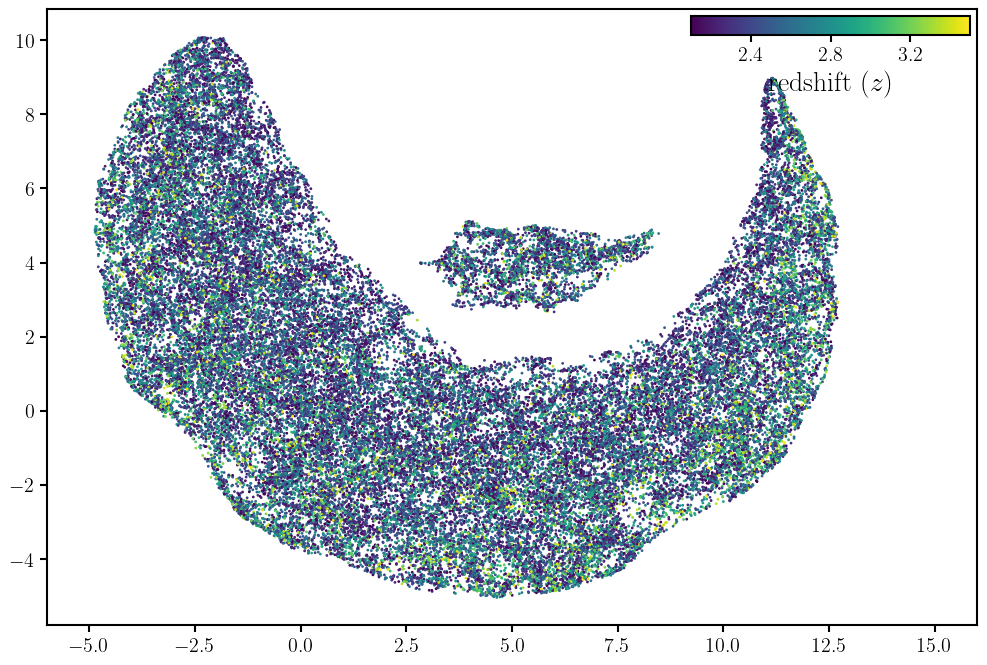

In [9]:
fig = plt.figure(figsize=(12,8))
sub = fig.add_subplot(111)
sc = sub.scatter(umapper.embedding_[:,0], umapper.embedding_[:,1], s=1,
                 c=redshifts, cmap='viridis', vmin=2.1, vmax=3.5, rasterized=True)

#sub.set_xticks([])
sub.set_xlim(-6, 16)
#sub.set_yticks([])

cbaxes = inset_axes(sub, width="30%", height="3%", loc='upper right') 
cbar = plt.colorbar(sc, cax=cbaxes, orientation='horizontal')
cbar.set_ticks([2.4, 2.8, 3.2])
cbar.set_label(label='redshift ($z$)', size=20)
#fig.savefig('london_latents.pdf')#, bbox_inches='tight')

## UMAP --- SNR

/tmp/ipykernel_2719290/3036785049.py:7: RuntimeWarning: divide by zero encountered in log10
  c=np.log10(median_snr), cmap='viridis', vmin=-1, vmax=1.5, rasterized=True)


(np.float64(-7.0), np.float64(16.0), np.float64(10.5), np.float64(-6.0))

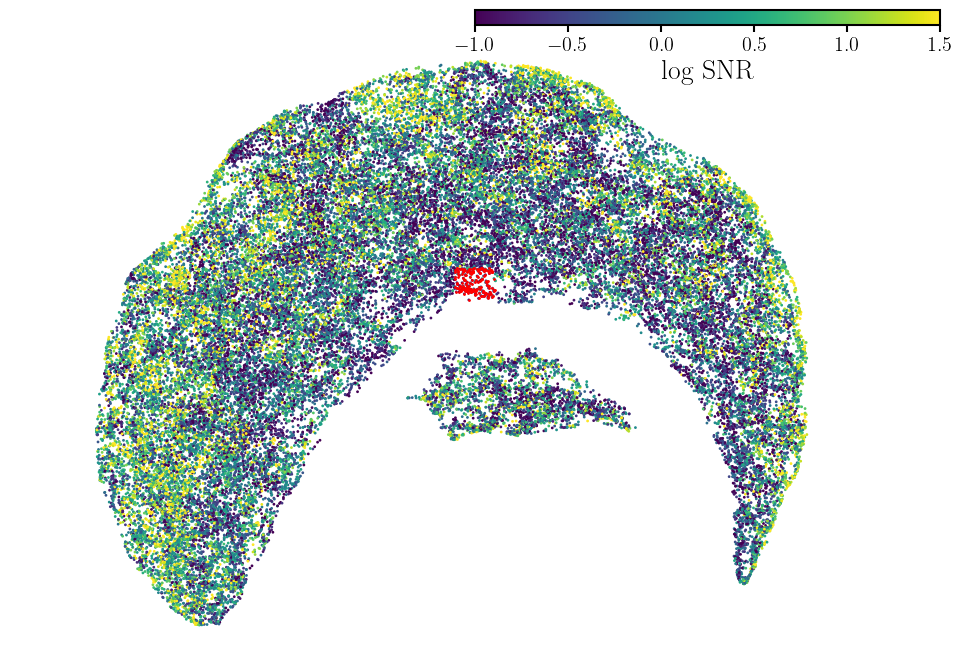

In [31]:
cluster = (umapper.embedding_[:,0] > 4) & (umapper.embedding_[:,0] < 5) & (umapper.embedding_[:,1] < 2) & (umapper.embedding_[:,1] > 0.5)
#& (umapper.embedding_[:,1] < -1.) & (umapper.embedding_[:,1] > -1.5)

fig = plt.figure(figsize=(12,8))
sub = fig.add_subplot(111)
sc = sub.scatter(umapper.embedding_[:,0], umapper.embedding_[:,1], s=1,
                 c=np.log10(median_snr), cmap='viridis', vmin=-1, vmax=1.5, rasterized=True)
sub.scatter(umapper.embedding_[:,0][cluster], umapper.embedding_[:,1][cluster], s=1, c='r')
cbaxes = sub.inset_axes([0.5, 1.0, 0.5, 0.025],
                               transform=sub.transAxes) 
cbar = plt.colorbar(sc, cax=cbaxes, orientation='horizontal')
cbar.set_label(label=r'$\log$ SNR', size=20)
    
sub.set_xticks([])
sub.set_xlim(-7, 16)
sub.set_yticks([])
sub.set_ylim([10.5, -6])
sub.axis('off')
#fig.savefig('latents_snr.pdf', bbox_inches='tight') 

170343061
160372857
170290982
170296836
170304122


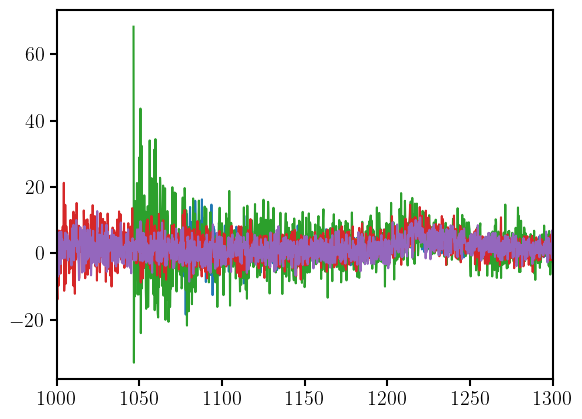

In [32]:
for igal in np.arange(specs.shape[0])[cluster][5:10]:
    print(tids[igal])
    plt.plot(models[0].wave_obs/(1+redshifts[igal]), specs[igal])
plt.xlim(1000., 1300)
plt.show()

160378505
160384653
160317925
160380589
160317332


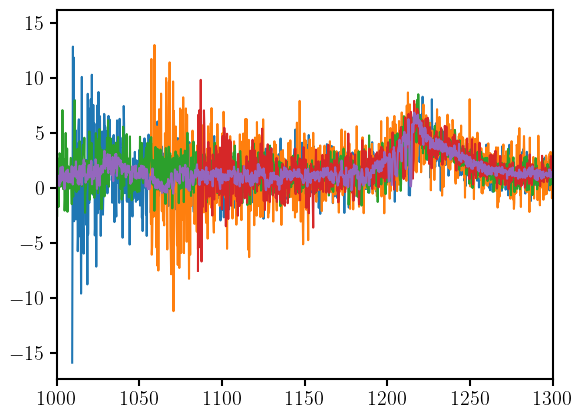

In [30]:
for igal in np.arange(specs.shape[0])[cluster][5:10]:
    print(tids[igal])
    plt.plot(models[0].wave_obs/(1+redshifts[igal]), specs[igal])
plt.xlim(1000., 1300)
plt.show()

In [ ]:
snr

In [13]:
cluster = (umapper.embedding_[:,0] > 2) & (umapper.embedding_[:,0] < 5) & (umapper.embedding_[:,1] > 3.5)

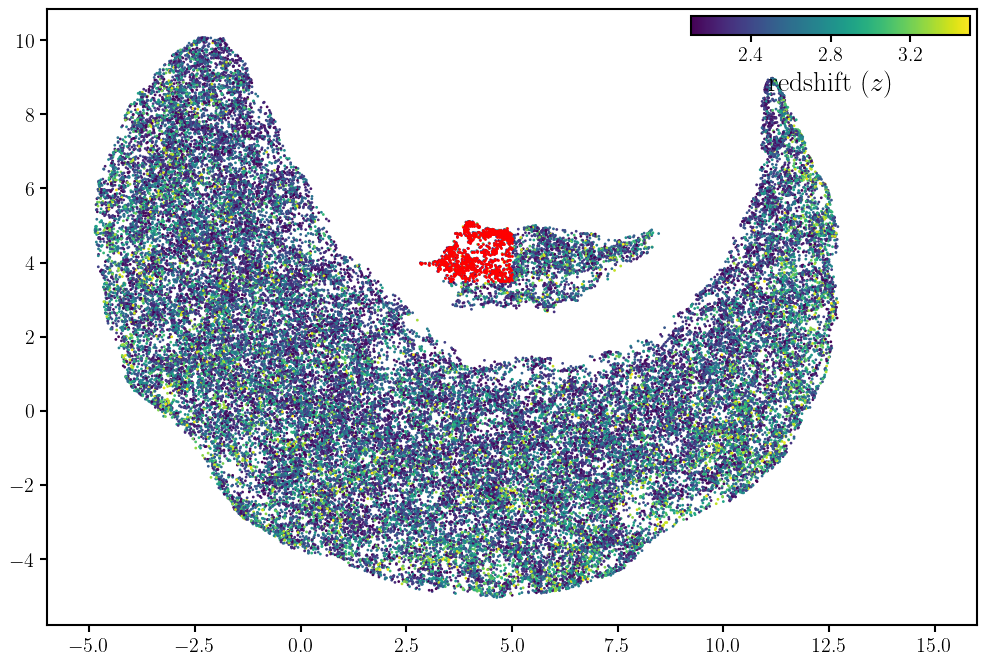

In [14]:
fig = plt.figure(figsize=(12,8))
sub = fig.add_subplot(111)
sc = sub.scatter(umapper.embedding_[:,0], umapper.embedding_[:,1], s=1,
                 c=redshifts, cmap='viridis', vmin=2.1, vmax=3.5, rasterized=True)
sub.scatter(umapper.embedding_[:,0][cluster], umapper.embedding_[:,1][cluster], s=1, c='r')
#sub.set_xticks([])
sub.set_xlim(-6, 16)
#sub.set_yticks([])

cbaxes = inset_axes(sub, width="30%", height="3%", loc='upper right') 
cbar = plt.colorbar(sc, cax=cbaxes, orientation='horizontal')
cbar.set_ticks([2.4, 2.8, 3.2])
cbar.set_label(label='redshift ($z$)', size=20)
#fig.savefig('london_latents.pdf')#, bbox_inches='tight')

160346097


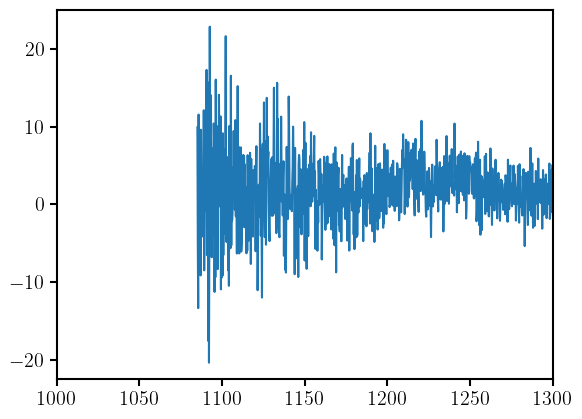

160360912


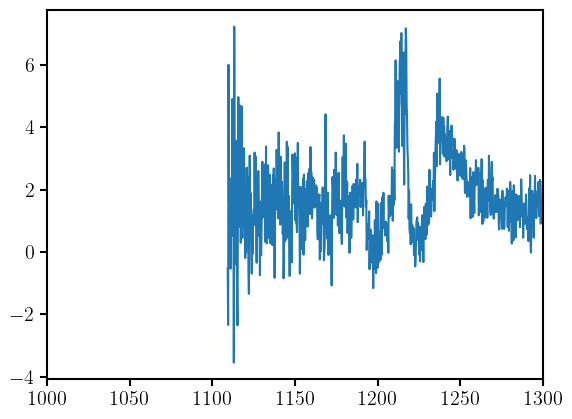

160365174


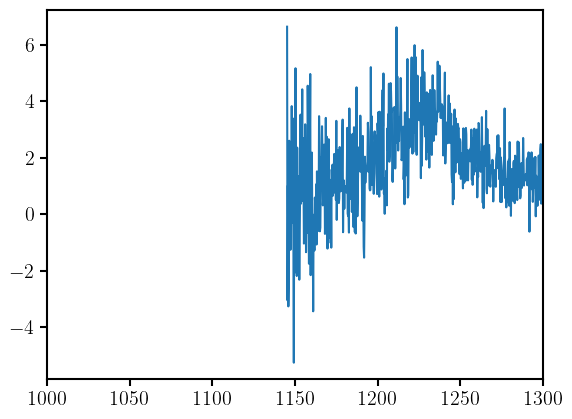

170264443


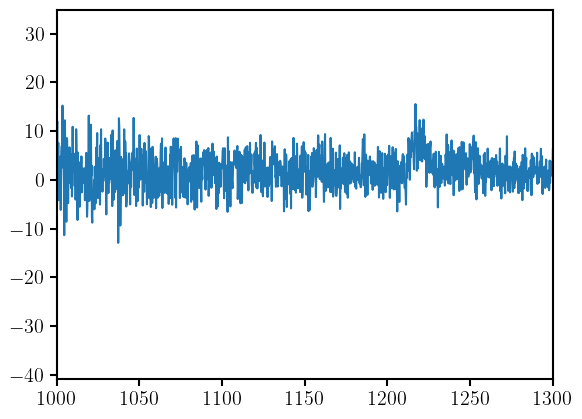

170267566


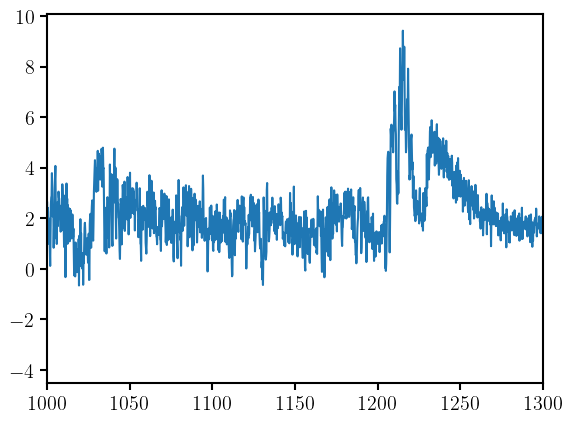

In [15]:
for igal in np.arange(specs.shape[0])[cluster][5:10]:
    print(tids[igal])
    plt.plot(models[0].wave_obs/(1+redshifts[igal]), specs[igal])
    plt.xlim(1000., 1300)
    plt.show()

In [16]:
tids[cluster]

array([170284047, 170334329, 170337890, 160273168, 160292463, 160346097,
       160360912, 160365174, 170264443, 170267566, 170272632, 170300820,
       170302425, 120175879, 160352618, 160364596, 130109927, 130111028,
       130149696, 170275894, 170341034, 170342212, 170349737, 130111313,
       160370128, 160371141, 160374239, 160375330, 160380835, 160382811,
       170292497, 170296289, 170307803, 170309742, 160317367, 160321822,
       160322803, 160331221, 160331267, 160352582, 160378725, 160381611,
       160275345, 160333941, 160341107, 160344593, 160345992, 160346418,
       120221888, 120227506, 170302628, 170346274, 170321300, 170362180,
       170365150, 170367556, 170378845, 160274082, 160323189, 160327056,
       160335276, 160338968, 160345117, 160345628, 160349166, 160361802,
        70002334,  70005485,  70041574,  70044844,  70044980, 100186412,
       100188774, 100197291, 100217046, 100221192, 100225776, 100229840,
       100231667, 100231692,  90105045,  90114377, 

## UMAP --- bad recon

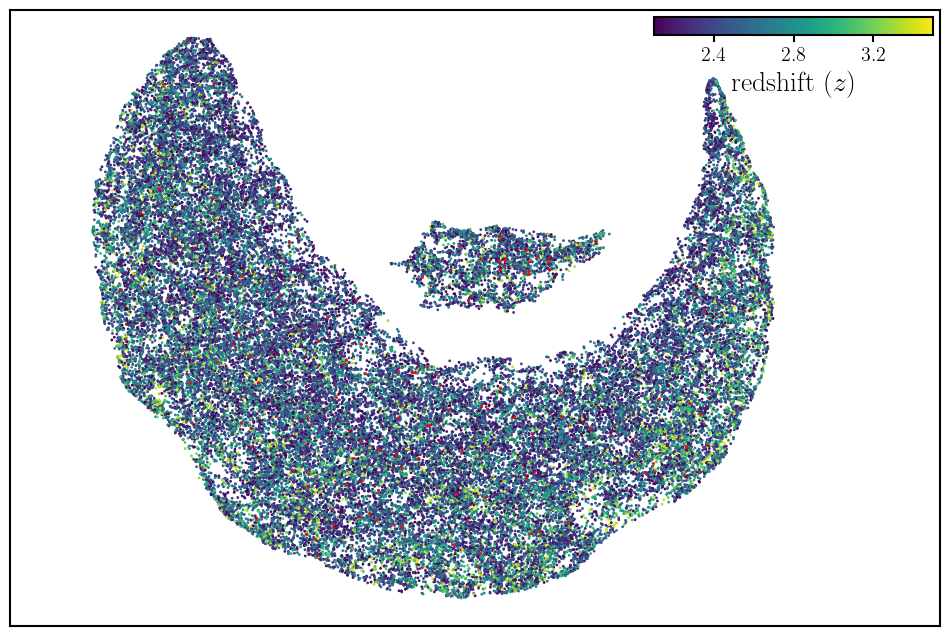

In [17]:
fig = plt.figure(figsize=(12,8))
sub = fig.add_subplot(111)
sc = sub.scatter(umapper.embedding_[:,0], umapper.embedding_[:,1], s=1,
                 c=redshifts, cmap='viridis', vmin=2.1, vmax=3.5, rasterized=True)
sub.scatter(umapper.embedding_[:,0][bad_recon], umapper.embedding_[:,1][bad_recon], s=1,
            c='r', rasterized=True)

sub.set_xticks([])
sub.set_xlim(-7, 17)
sub.set_yticks([])

cbaxes = inset_axes(sub, width="30%", height="3%", loc='upper right') 
cbar = plt.colorbar(sc, cax=cbaxes, orientation='horizontal')
cbar.set_ticks([2.4, 2.8, 3.2])
cbar.set_label(label='redshift ($z$)', size=20)
#fig.savefig('london_latents.pdf')#, bbox_inches='tight')

# UMAP --- masking

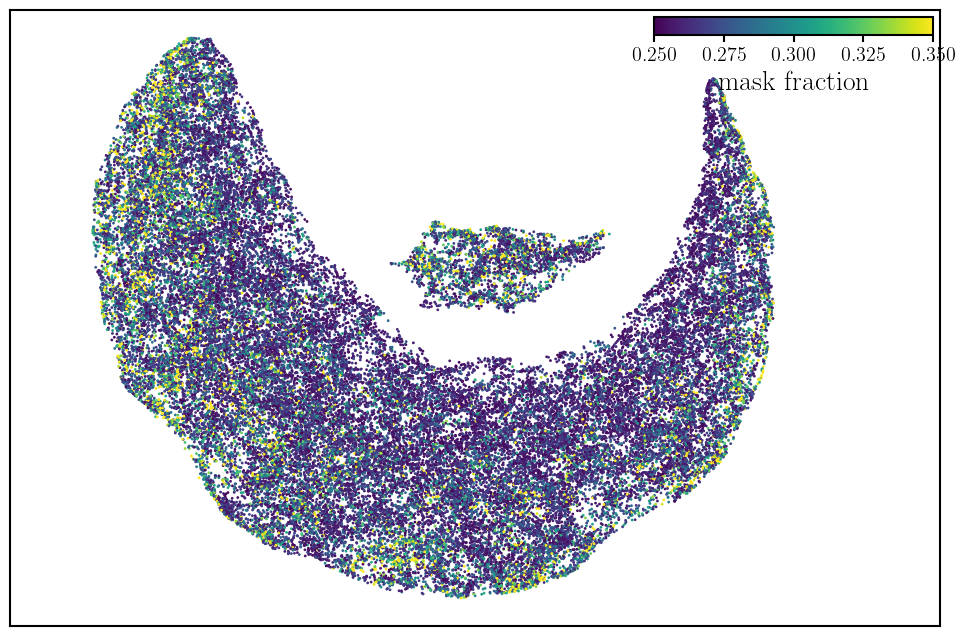

In [18]:
fig = plt.figure(figsize=(12,8))
sub = fig.add_subplot(111)
sc = sub.scatter(umapper.embedding_[:,0], umapper.embedding_[:,1], s=1,
                 c=np.mean(weights == 0., axis=1), cmap='viridis', vmin=0.25, vmax=0.35, rasterized=True)

sub.set_xticks([])
sub.set_xlim(-7, 17)
sub.set_yticks([])

cbaxes = inset_axes(sub, width="30%", height="3%", loc='upper right') 
cbar = plt.colorbar(sc, cax=cbaxes, orientation='horizontal')
#cbar.set_ticks([2.4, 2.8, 3.2])
cbar.set_label(label='mask fraction', size=20)
#fig.savefig('london_latents.pdf')#, bbox_inches='tight')

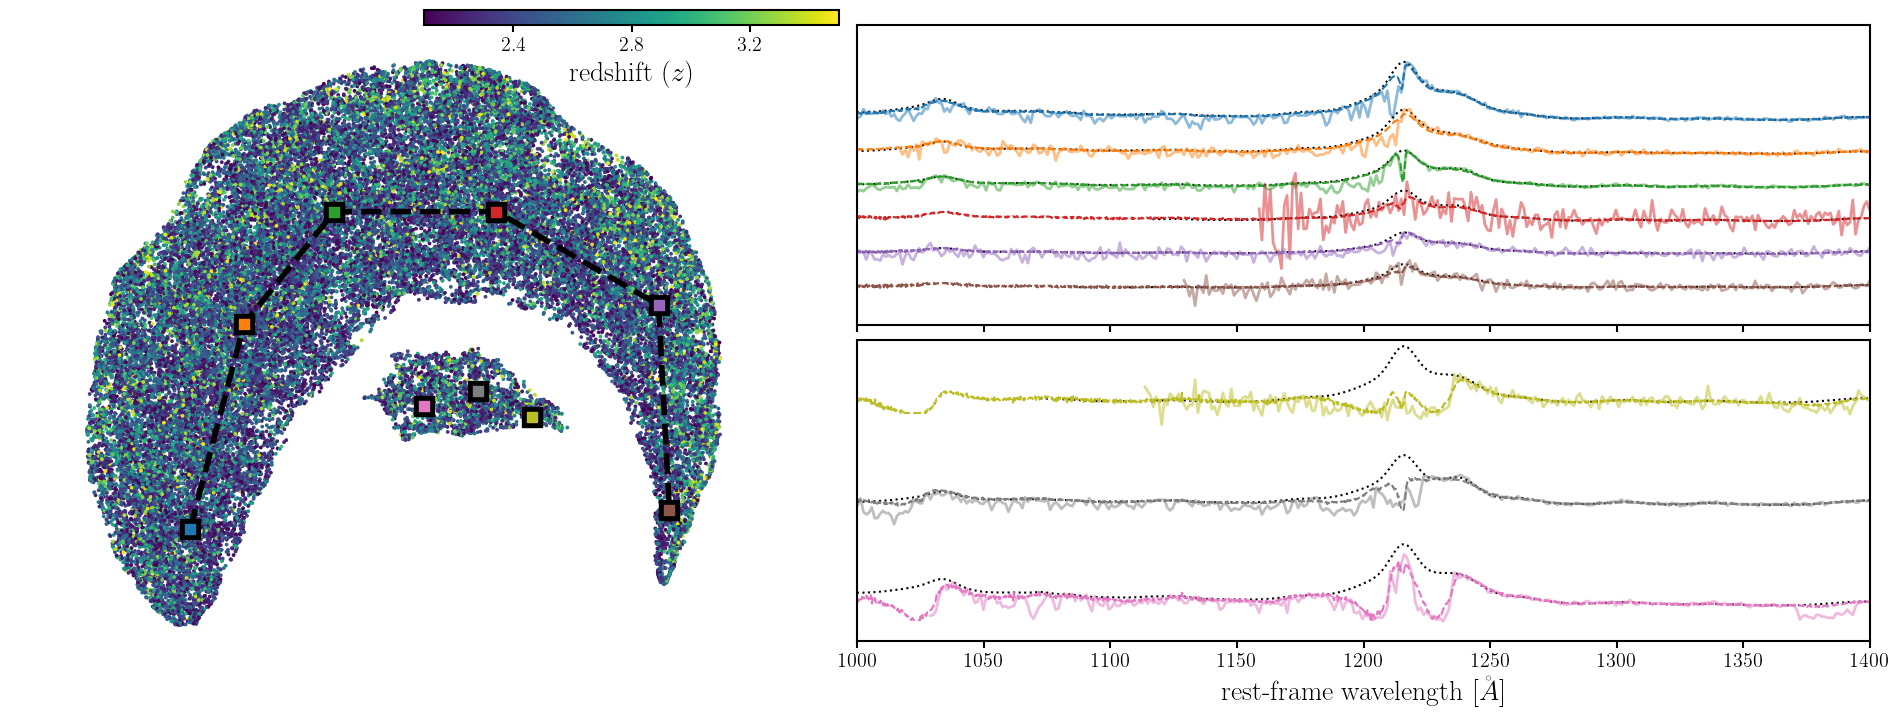

In [14]:
#track1 = np.array([(-1.0, -1.5), (-1., 6), (2.5, 10.0), (7.0, 11.0), (11.0, 7.), (11.2, 0.)])
#track2 = np.array([(-2.5, -0.0), (-3., 7), (1.0, 13.0), (8.0, 14.0), (12.5, 9.), (12.0, 2.)])
#track2 = np.array([(-1.0, -1.5), (-2., 6.5), (1.5, 11.5), (7.5, 12.), (12.0, 8.), (11.2, 0.)])
track2 = np.array([(-2., 7.5), (-0.5, 2.), (2., -1), (6.5, -1), (11., 1.5), (11.3, 7.)])


bad_track = np.array([(4.5, 4.2), (6., 3.8), (7.5, 4.5)])


fig = plt.figure(figsize=(24, 8))
gs0 = mpl.gridspec.GridSpec(1, 2, figure=fig, width_ratios=(0.45, 0.55))

sub = plt.subplot(gs0[0])
sc = sub.scatter(umapper.embedding_[:,0], umapper.embedding_[:,1], s=3,
                 c=redshifts, cmap='viridis', vmin=2.1, vmax=3.5, rasterized=True)

for ii, point in enumerate(bad_track): 
    sub.scatter([point[0]], [point[1]], marker='s', s=200, c='k', zorder=10)
    sub.scatter([point[0]], [point[1]], marker='s', s=50, c='C%i' % (ii+6), zorder=11)

# sub.plot(track1[:,0], track1[:,1], lw=2, ls='--', c='white')
# for ii, point in enumerate(track1): 
#     sub.scatter([point[0]], [point[1]], marker='s', s=150, c='white', zorder=10)
#     sub.scatter([point[0]], [point[1]], marker='s', s=30, c='C%i' % ii, zorder=11)
    
sub.plot(track2[:,0], track2[:,1], lw=4, ls='--', c='k')
for ii, point in enumerate(track2): 
    sub.scatter([point[0]], [point[1]], marker='s', s=200, c='k', zorder=10)
    sub.scatter([point[0]], [point[1]], marker='s', s=50, c='C%i' % ii, zorder=11)
    
sub.set_xticks([])
sub.set_xlim(-7, 16)
sub.set_yticks([])
sub.set_ylim([10.5, -6])
sub.axis('off')

# cbaxes = inset_axes(sub, width="30%", height="3%", loc='upper right') 
# cbar = plt.colorbar(sc, cax=cbaxes, orientation='horizontal')
# cbar.set_ticks([2.4, 2.8, 3.2])
# cbar.set_label(label='redshift ($z$)', size=20)

cbaxes = sub.inset_axes([0.5, 1.0, 0.5, 0.025],
                               transform=sub.transAxes) 
cbar = plt.colorbar(sc, ticks=[2.4, 2.8, 3.2], cax=cbaxes, orientation='horizontal')
cbar.set_label(label='redshift ($z$)', size=20)

sub_right = mpl.gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[1])

sub = plt.subplot(sub_right[1])
for ii, point in enumerate(bad_track): 
    igal = np.argmin((umapper.embedding_[:,0] - point[0])**2 + (umapper.embedding_[:,1] - point[1])**2)        
    wlim = ((wave_rest_rebin > np.max([900., models[0].wave_obs[0]/(1.+redshifts[igal])])+10.) & 
            (wave_rest_rebin < 1400.))
    _spec = U.trapz_rebin(np.array(models[0].wave_obs/(1.+redshifts[igal])), 
                                      np.array(specs[igal,:]), xnew=wave_rest_rebin[wlim])
    sub.plot(np.linspace(3.50e3, 1e4, 3251)/float(1 + redshifts[igal]), 
             (true_cont[igal]/norms[igal])+10*ii, c='k', ls=':')    
    sub.plot(wave_rest_rebin[wlim], _spec+10*ii, c='C%i' % (ii+6), lw=2, alpha=0.5)
    sub.plot(w_recon, recon[igal]+10*ii, c='C%i' % (ii+6), ls='--')

sub.set_xlim(1000., 1400.)
sub.set_xlabel(r"rest-frame wavelength [$\AA$]", fontsize=20)
sub.set_ylim(-2., 27)
sub.set_yticks([])

    
sub = plt.subplot(sub_right[0])
for ii, point in enumerate(track2): 
    igal = np.argmin((umapper.embedding_[:,0] - point[0])**2 + (umapper.embedding_[:,1] - point[1])**2)
    #sub.plot(models[0].wave_obs/(1.+redshifts[iclosest]), specs[iclosest,:], c='C%i' % ii, lw=2)
        
    wlim = ((wave_rest_rebin > np.max([900., models[0].wave_obs[0]/(1.+redshifts[igal])])+10.) & 
            (wave_rest_rebin < 1400.))
    _spec = U.trapz_rebin(np.array(models[0].wave_obs/(1.+redshifts[igal])), 
                                      np.array(specs[igal,:]), xnew=wave_rest_rebin[wlim])
    sub.plot(np.linspace(3.50e3, 1e4, 3251)/float(1 + redshifts[igal]), 
             (true_cont[igal]/norms[igal])+5*(6-ii), c='k', ls=':')    
    sub.plot(wave_rest_rebin[wlim], _spec+5*(6-ii), c='C%i' % ii, lw=2, alpha=0.5)
    sub.plot(w_recon, recon[igal]+5*(6-ii), c='C%i' % ii, ls='--')    
    
sub.set_xlim(1000., 1400.)
sub.set_xticklabels([])
sub.set_ylim(0., 46)
sub.set_yticks([])
fig.subplots_adjust(hspace=0.05, wspace=0.02)

fig.savefig('latents_demo.pdf', bbox_inches='tight')

In [9]:
from astropy.table import Table 

bal = Table.read('/tigress/chhahn/spender_qso/london/contamin/bal_cat.fits')
dla = Table.read('/tigress/chhahn/spender_qso/london/contamin/dla_cat_mask_20.30.fits')

In [10]:
is_bal = np.zeros(len(tids)).astype(bool)
is_dla = np.zeros(len(tids)).astype(bool)
for i, tid in enumerate(tids): 
    if tid in bal['TARGETID']: 
        is_bal[i] = True
    if tid in dla['TARGETID']: 
        is_dla[i] = True

In [11]:
print(np.sum(is_bal), np.sum(is_dla), np.sum(is_dla & is_bal))

8170 5836 924


/tmp/ipykernel_2719290/2565538232.py:59: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  _spec = U.trapz_rebin(np.array(models[0].wave_obs/(1.+redshifts[igal])),
/tmp/ipykernel_2719290/2565538232.py:79: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  _spec = U.trapz_rebin(np.array(models[0].wave_obs/(1.+redshifts[igal])),
/tmp/ipykernel_2719290/2565538232.py:95: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  _spec = U.trapz_rebin(np.array(models[0].wave_obs/(1.+redshifts[igal])),


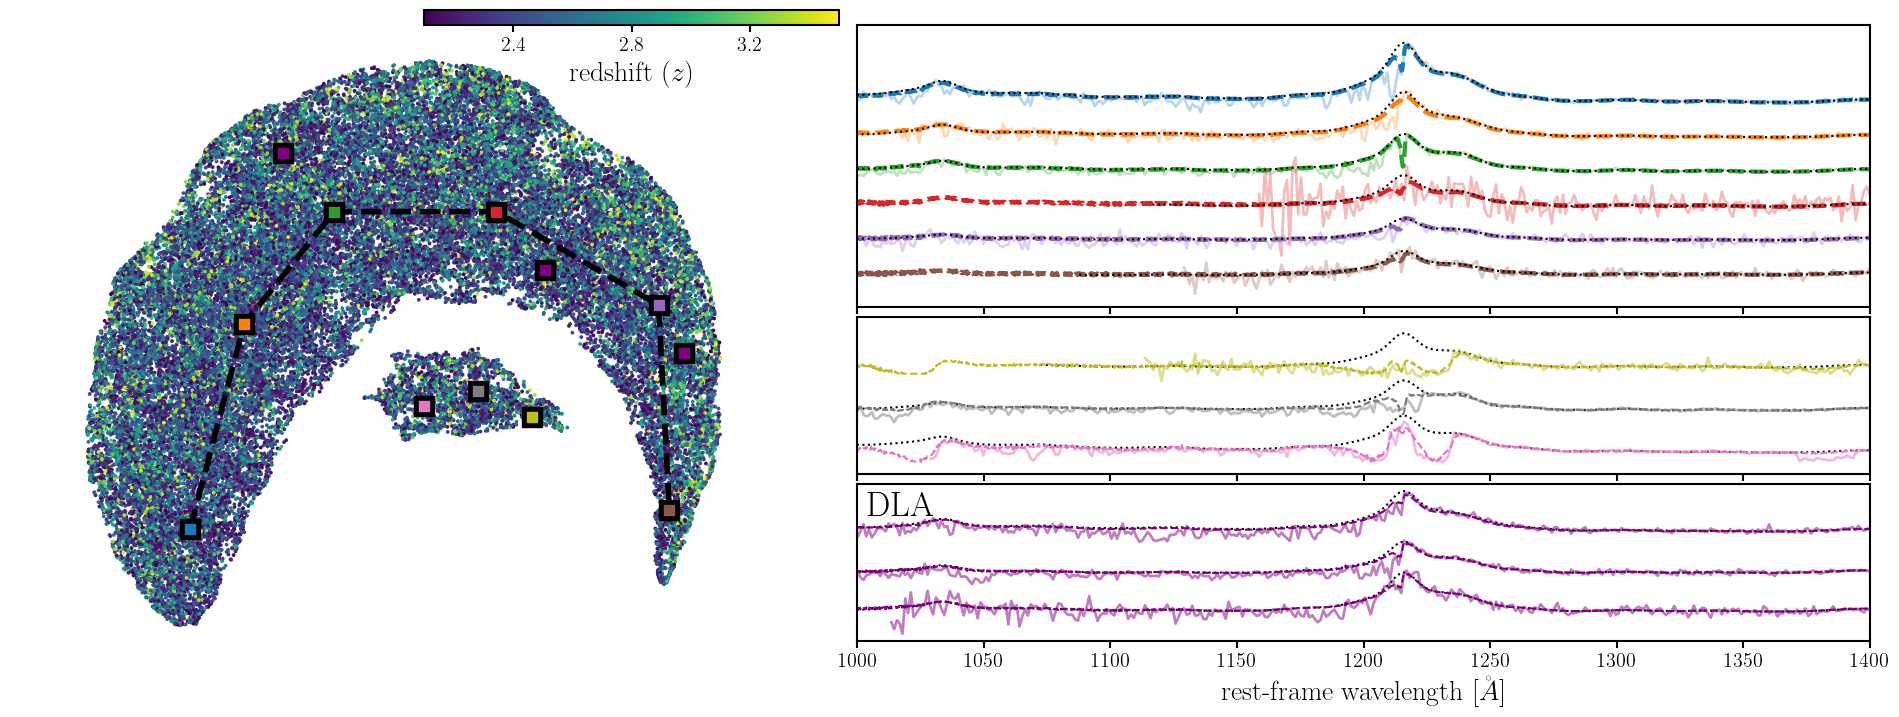

In [22]:
#track1 = np.array([(-1.0, -1.5), (-1., 6), (2.5, 10.0), (7.0, 11.0), (11.0, 7.), (11.2, 0.)])
#track2 = np.array([(-2.5, -0.0), (-3., 7), (1.0, 13.0), (8.0, 14.0), (12.5, 9.), (12.0, 2.)])
#track2 = np.array([(-1.0, -1.5), (-2., 6.5), (1.5, 11.5), (7.5, 12.), (12.0, 8.), (11.2, 0.)])
track2 = np.array([(-2., 7.5), (-0.5, 2.), (2., -1), (6.5, -1), (11., 1.5), (11.3, 7.)])


bad_track = np.array([(4.5, 4.2), (6., 3.8), (7.5, 4.5)])


fig = plt.figure(figsize=(24, 8))
gs0 = mpl.gridspec.GridSpec(1, 2, figure=fig, width_ratios=(0.45, 0.55))

sub = plt.subplot(gs0[0])
sc = sub.scatter(umapper.embedding_[:,0], umapper.embedding_[:,1], s=3,
                 c=redshifts, cmap='viridis', vmin=2.1, vmax=3.5, rasterized=True)

for ii, point in enumerate(bad_track): 
    sub.scatter([point[0]], [point[1]], marker='s', s=200, c='k', zorder=10)
    sub.scatter([point[0]], [point[1]], marker='s', s=50, c='C%i' % (ii+6), zorder=11)

# sub.plot(track1[:,0], track1[:,1], lw=2, ls='--', c='white')
# for ii, point in enumerate(track1): 
#     sub.scatter([point[0]], [point[1]], marker='s', s=150, c='white', zorder=10)
#     sub.scatter([point[0]], [point[1]], marker='s', s=30, c='C%i' % ii, zorder=11)
    
sub.plot(track2[:,0], track2[:,1], lw=4, ls='--', c='k')
for ii, point in enumerate(track2): 
    sub.scatter([point[0]], [point[1]], marker='s', s=200, c='k', zorder=10)
    sub.scatter([point[0]], [point[1]], marker='s', s=50, c='C%i' % ii, zorder=11)

for ii, igal in enumerate(np.arange(len(tids))[is_dla][np.array([1,2,8])]): 
    sub.scatter([umapper.embedding_[igal,0]], [umapper.embedding_[igal,1]], marker='s', s=200, c='k', zorder=10)
    sub.scatter([umapper.embedding_[igal,0]], [umapper.embedding_[igal,1]], marker='s', s=50, c='purple', zorder=11)

    
sub.set_xticks([])
sub.set_xlim(-7, 16)
sub.set_yticks([])
sub.set_ylim([10.5, -6])
sub.axis('off')

# cbaxes = inset_axes(sub, width="30%", height="3%", loc='upper right') 
# cbar = plt.colorbar(sc, cax=cbaxes, orientation='horizontal')
# cbar.set_ticks([2.4, 2.8, 3.2])
# cbar.set_label(label='redshift ($z$)', size=20)

cbaxes = sub.inset_axes([0.5, 1.0, 0.5, 0.025],
                               transform=sub.transAxes) 
cbar = plt.colorbar(sc, ticks=[2.4, 2.8, 3.2], cax=cbaxes, orientation='horizontal')
cbar.set_label(label='redshift ($z$)', size=20)

sub_right = mpl.gridspec.GridSpecFromSubplotSpec(3,1, subplot_spec=gs0[1], height_ratios=[1.8, 1, 1])

sub = plt.subplot(sub_right[1])
for ii, point in enumerate(bad_track): 
    igal = np.argmin((umapper.embedding_[:,0] - point[0])**2 + (umapper.embedding_[:,1] - point[1])**2)        
    wlim = ((wave_rest_rebin > np.max([900., models[0].wave_obs[0]/(1.+redshifts[igal])])+10.) & 
            (wave_rest_rebin < 1400.))
    _spec = U.trapz_rebin(np.array(models[0].wave_obs/(1.+redshifts[igal])), 
                                      np.array(specs[igal,:]), xnew=wave_rest_rebin[wlim])
    sub.plot(np.linspace(3.50e3, 1e4, 3251)/float(1 + redshifts[igal]), 
             (true_cont[igal]/norms[igal])+7*ii, c='k', ls=':')    
    sub.plot(wave_rest_rebin[wlim], _spec+7*ii, c='C%i' % (ii+6), lw=2, alpha=0.5)
    sub.plot(w_recon, recon[igal]+7*ii, c='C%i' % (ii+6), ls='--')

sub.set_xlim(1000., 1400.)
sub.set_xticklabels([])
sub.set_ylim(-2., 23)
sub.set_yticks([])

    
sub = plt.subplot(sub_right[0])
for ii, point in enumerate(track2): 
    igal = np.argmin((umapper.embedding_[:,0] - point[0])**2 + (umapper.embedding_[:,1] - point[1])**2)
    #sub.plot(models[0].wave_obs/(1.+redshifts[iclosest]), specs[iclosest,:], c='C%i' % ii, lw=2)
        
    wlim = ((wave_rest_rebin > np.max([900., models[0].wave_obs[0]/(1.+redshifts[igal])])+10.) & 
            (wave_rest_rebin < 1400.))
    _spec = U.trapz_rebin(np.array(models[0].wave_obs/(1.+redshifts[igal])), 
                                      np.array(specs[igal,:]), xnew=wave_rest_rebin[wlim])
    sub.plot(wave_rest_rebin[wlim], _spec+5*(6-ii), c='C%i' % ii, lw=2, alpha=0.3)
    sub.plot(w_recon, recon[igal]+5*(6-ii), c='C%i' % ii, ls='--', lw=3)    
    sub.plot(np.linspace(3.50e3, 1e4, 3251)/float(1 + redshifts[igal]), 
             (true_cont[igal]/norms[igal])+5*(6-ii), c='k', ls=':')        
    
sub.set_xlim(1000., 1400.)
sub.set_xticklabels([])
sub.set_ylim(1., 43)
sub.set_yticks([])

sub = plt.subplot(sub_right[2])
for ii, igal in enumerate(np.arange(len(tids))[is_dla][np.array([1,2,8])]): 
    wlim = ((wave_rest_rebin > np.max([900., models[0].wave_obs[0]/(1.+redshifts[igal])])+10.) & 
            (wave_rest_rebin < 1400.))
    _spec = U.trapz_rebin(np.array(models[0].wave_obs/(1.+redshifts[igal])), 
                                      np.array(specs[igal,:]), xnew=wave_rest_rebin[wlim])
    sub.plot(np.linspace(3.50e3, 1e4, 3251)/float(1 + redshifts[igal]), 
             (true_cont[igal]/norms[igal])+5*(6-ii), c='k', ls=':')    
    sub.plot(wave_rest_rebin[wlim], _spec+5*(6-ii), c='purple', lw=2, alpha=0.5)
    sub.plot(w_recon, recon[igal]+5*(6-ii), c='purple', ls='--')    

sub.text(0.01, 0.95, 'DLA', ha='left', va='top', fontsize=25, transform=sub.transAxes)
sub.set_xlim(1000., 1400.)
sub.set_xlabel(r"rest-frame wavelength [$\AA$]", fontsize=20)

#sub.set_ylim(0., 46)
sub.set_yticks([])

fig.subplots_adjust(hspace=0.05, wspace=0.02)

fig.savefig('latents_demo.pdf', bbox_inches='tight')

# BAL and DAL check

In [10]:
from astropy.table import Table

In [11]:
bal = Table.read('/tigress/chhahn/spender_qso/london/contamin/bal_cat.fits')
hcd = Table.read('/tigress/chhahn/spender_qso/london/contamin/dla_cat.fits')
dla = Table.read('/tigress/chhahn/spender_qso/london/contamin/dla_cat_mask_20.30.fits')

In [12]:
is_bal = np.zeros(len(tids)).astype(bool)
is_hcd = np.zeros(len(tids)).astype(bool)
is_dla = np.zeros(len(tids)).astype(bool)
for i in range(len(tids)): 
    if tids[i] in bal['TARGETID']: is_bal[i] = True
    if tids[i] in hcd['TARGETID']: is_hcd[i] = True
    if tids[i] in dla['TARGETID']: is_dla[i] = True        

In [13]:
np.sum(is_bal), np.sum(is_hcd), np.sum(is_dla)

(np.int64(8170), np.int64(26781), np.int64(5836))

[]

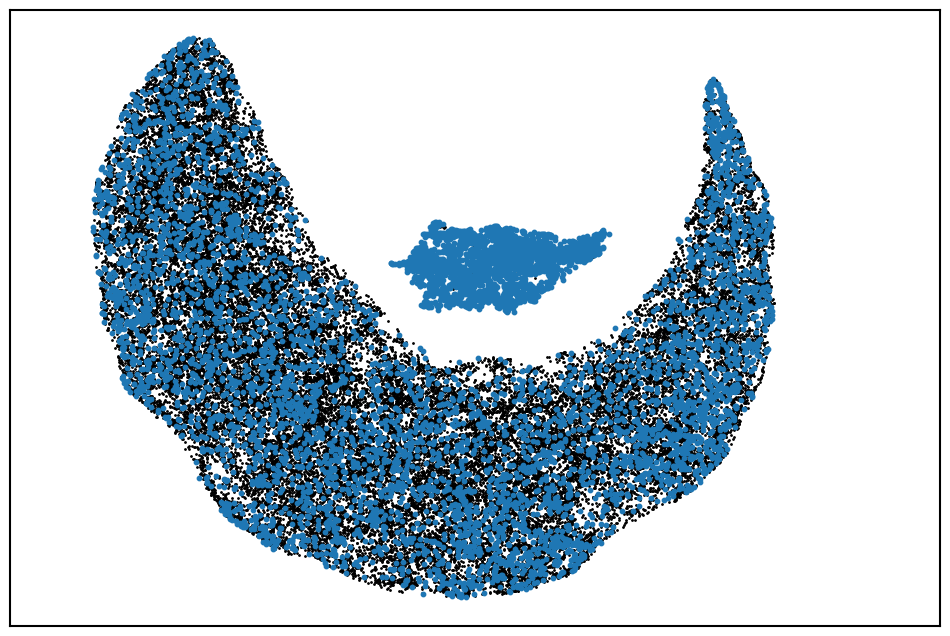

In [15]:
fig = plt.figure(figsize=(12,8))
sub = fig.add_subplot(111)
sc = sub.scatter(umapper.embedding_[:,0], umapper.embedding_[:,1], s=1, c='k')
sub.scatter(umapper.embedding_[:,0][is_bal], umapper.embedding_[:,1][is_bal], s=10,
            c='C0', rasterized=True)
#sub.scatter(umapper.embedding_[:,0][is_hcd], umapper.embedding_[:,1][is_hcd], s=10,
#            c='C1', rasterized=True)
#sub.scatter(umapper.embedding_[:,0][is_dla], umapper.embedding_[:,1][is_dla], s=10,
#            c='C2', rasterized=True)

sub.set_xticks([])
sub.set_xlim(-7, 17)
sub.set_yticks([])

# cbaxes = inset_axes(sub, width="30%", height="3%", loc='upper right') 
# cbar = plt.colorbar(sc, cax=cbaxes, orientation='horizontal')
# cbar.set_ticks([2.4, 2.8, 3.2])
# cbar.set_label(label='redshift ($z$)', size=20)
#fig.savefig('london_latents.pdf')#, bbox_inches='tight')

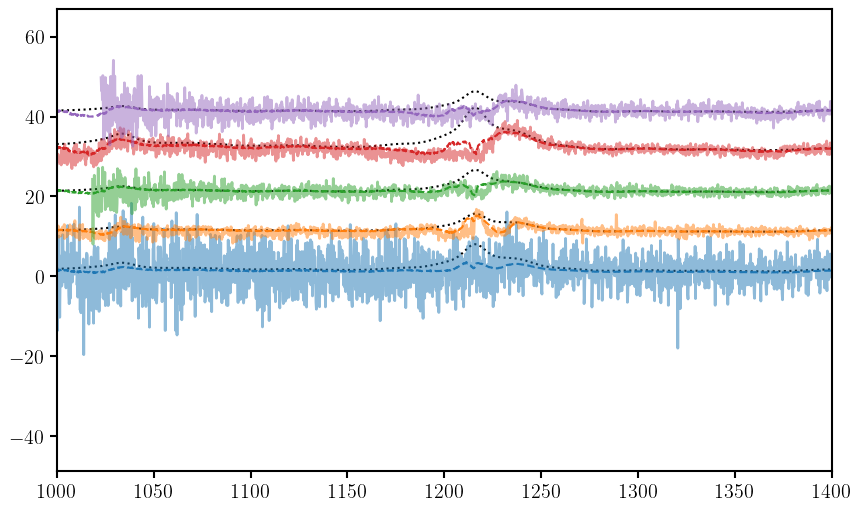

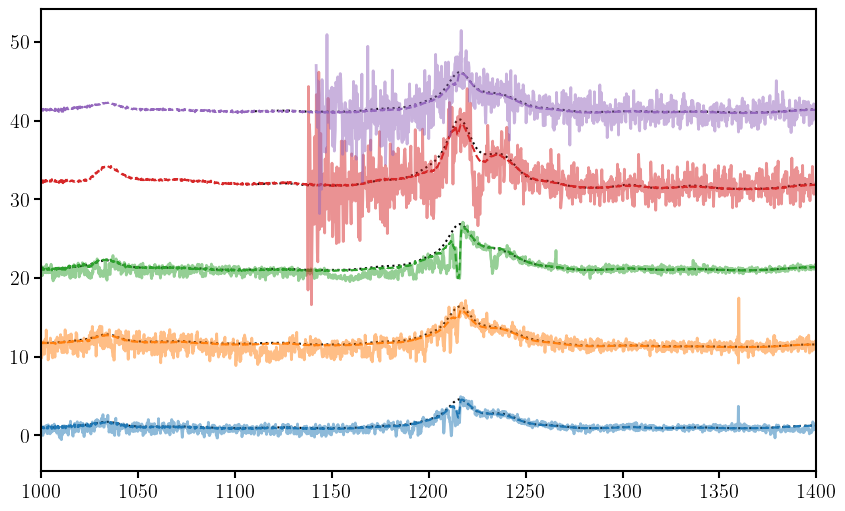

In [45]:
fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)

for ii, igal in enumerate(np.arange(len(tids))[cluster & is_bal][:5]): 
    sub.plot(np.linspace(3.50e3, 1e4, 3251)/float(1 + redshifts[igal]), 
             (true_cont[igal]/norms[igal])+ii*10, c='k', ls=':')    
    sub.plot(models[0].wave_obs/(1.+redshifts[igal]), specs[igal]+ii*10, c='C%i' % ii, lw=2, alpha=0.5)
    sub.plot(w_recon, recon[igal]+ii*10, c='C%i' % ii, ls='--')   
    
sub.set_xlim(1000., 1400.)
plt.show()

fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)

for ii, igal in enumerate(np.arange(len(tids))[~cluster & is_bal][:5]): 
    sub.plot(np.linspace(3.50e3, 1e4, 3251)/float(1 + redshifts[igal]), 
             (true_cont[igal]/norms[igal])+ii*10, c='k', ls=':')    
    sub.plot(models[0].wave_obs/(1.+redshifts[igal]), specs[igal]+ii*10, c='C%i' % ii, lw=2, alpha=0.5)
    sub.plot(w_recon, recon[igal]+ii*10, c='C%i' % ii, ls='--')   
    
sub.set_xlim(1000., 1400.)
plt.show()

In [33]:
cluster = (((umapper.embedding_[:,0] > 3.25) & (umapper.embedding_[:,0] < 8.5) & 
           (umapper.embedding_[:,1] < 7.5) & (umapper.embedding_[:,1] > 2.)) | 
           ((umapper.embedding_[:,0] > 2.5) & (umapper.embedding_[:,0] < 8.5) & 
           (umapper.embedding_[:,1] < 7.5) & (umapper.embedding_[:,1] > 3.)))


[]

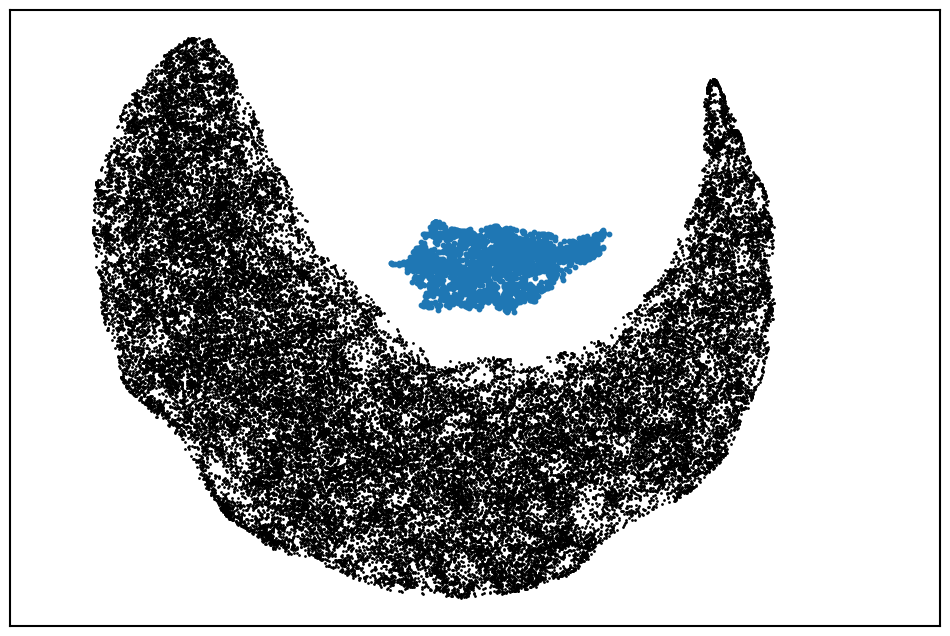

In [40]:
fig = plt.figure(figsize=(12,8))
sub = fig.add_subplot(111)
sc = sub.scatter(umapper.embedding_[:,0], umapper.embedding_[:,1], s=1, c='k')
sub.scatter(umapper.embedding_[:,0][cluster], umapper.embedding_[:,1][cluster], s=10,
            c='C0', rasterized=True)

sub.set_xticks([])
sub.set_xlim(-7, 17)
sub.set_yticks([])

In [39]:
print(np.sum(cluster & (is_bal)) / np.sum(cluster))
print(np.sum(cluster & (is_bal | is_dla)) / np.sum(cluster))
print(np.sum(cluster & (is_bal | is_dla | is_hcd)) / np.sum(cluster))

0.9525458953931417
0.9906477312088673
0.9961898164184274


In [41]:
np.sum(cluster & ~(is_bal | is_dla | is_hcd))

np.int64(11)

(1000.0, 1400.0)

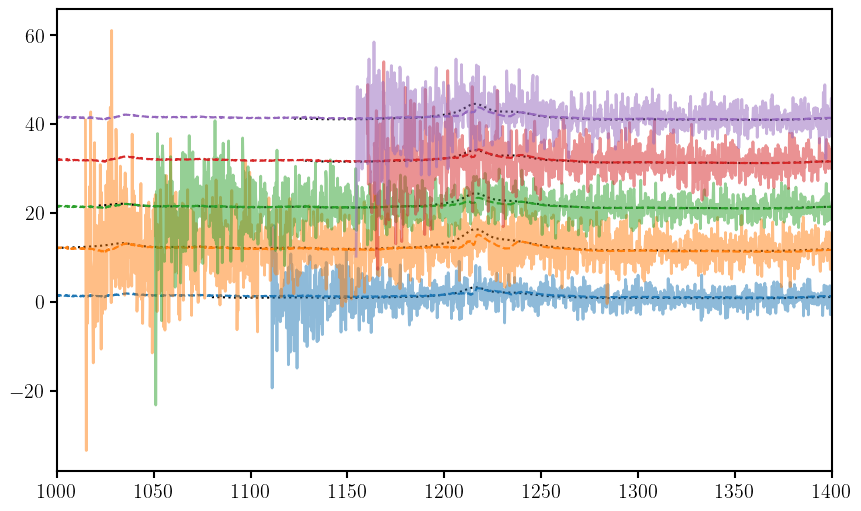

In [42]:
fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)

for ii, igal in enumerate(np.arange(len(tids))[cluster & ~(is_bal | is_dla | is_hcd)][:5]): 
    sub.plot(np.linspace(3.50e3, 1e4, 3251)/float(1 + redshifts[igal]), 
             (true_cont[igal]/norms[igal])+ii*10, c='k', ls=':')    
    sub.plot(models[0].wave_obs/(1.+redshifts[igal]), specs[igal]+ii*10, c='C%i' % ii, lw=2, alpha=0.5)
    sub.plot(w_recon, recon[igal]+ii*10, c='C%i' % ii, ls='--')   
    
sub.set_xlim(1000., 1400.)
